In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import date
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

import datajoint as dj
import static_nda as nda
from stimulus import stimulus
from pipeline import experiment
from pipeline.utils.h5 import read_behavior_file


Loading local settings from pipeline_config.json
Connecting pfahey@at-database.ad.bcm.edu:3306


In [2]:
# scan_keys = nda.Scan.proj()
scan_keys = nda.ScanInclude.proj()

In [3]:
flip_df = []
for key in tqdm(scan_keys):
    session_date = (experiment.Session & key).fetch1('session_date')
    scan_path = (experiment.Scan & key).local_filenames_as_wildcard
    scan_dir = os.path.split(scan_path)[0]

    scan_file = (experiment.Scan & key).fetch1('filename')
    behavior_file = (experiment.Scan.BehaviorFile() & key).fetch1('filename')

    full_scan_file = os.path.join(scan_dir, f"{scan_file}_00001.tif")
    full_beh_file = os.path.join(scan_dir, behavior_file)

    scan_on = os.path.isfile(full_scan_file)
    data = read_behavior_file(full_beh_file)

    PD = data["syncPd"]
    
    key_str = '_'.join([str(s) for s in key.values()])
    median_peak = np.nanmedian(PD[PD>np.nanpercentile(PD,80)])
    median_valley = np.nanmedian(PD[PD<np.nanpercentile(PD,40)])
    flip_df.append({'key':key,'PD':PD[::500],'median_peak':median_peak,'median_valley':median_valley})
flip_df = pd.DataFrame(flip_df)
display(flip_df)

100%|██████████| 7/7 [03:47<00:00, 32.51s/it]


,key,PD,median_peak,median_valley
0,"{'animal_id': 21067, 'session': 10, 'scan_idx'...","[0.015272626051547293, 0.015272626051547293, 0...",0.460441,0.020208
1,"{'animal_id': 22846, 'session': 10, 'scan_idx'...","[0.01790481129657433, 0.018233834451780874, 0....",0.466692,0.023169
2,"{'animal_id': 23343, 'session': 5, 'scan_idx':...","[0.014943602895497054, 0.014943602895497054, 0...",0.461757,0.019879
3,"{'animal_id': 23656, 'session': 14, 'scan_idx'...","[0.01625969551913552, 0.015272626051547293, 0....",0.457809,0.020537
4,"{'animal_id': 23964, 'session': 4, 'scan_idx':...","[0.01658871867481077, 0.016917741830392272, 0....",0.452544,0.021524
5,"{'animal_id': 26644, 'session': 14, 'scan_idx'...","[0.023169181768631437, 0.023169181768631437, 0...",0.391017,0.027117
6,"{'animal_id': 26645, 'session': 2, 'scan_idx':...","[0.013956533426783813, 0.014943602895497054, 0...",0.383120,0.020866


In [4]:
flip_df

,key,PD,median_peak,median_valley
0,"{'animal_id': 21067, 'session': 10, 'scan_idx'...","[0.015272626051547293, 0.015272626051547293, 0...",0.460441,0.020208
1,"{'animal_id': 22846, 'session': 10, 'scan_idx'...","[0.01790481129657433, 0.018233834451780874, 0....",0.466692,0.023169
2,"{'animal_id': 23343, 'session': 5, 'scan_idx':...","[0.014943602895497054, 0.014943602895497054, 0...",0.461757,0.019879
3,"{'animal_id': 23656, 'session': 14, 'scan_idx'...","[0.01625969551913552, 0.015272626051547293, 0....",0.457809,0.020537
4,"{'animal_id': 23964, 'session': 4, 'scan_idx':...","[0.01658871867481077, 0.016917741830392272, 0....",0.452544,0.021524
5,"{'animal_id': 26644, 'session': 14, 'scan_idx'...","[0.023169181768631437, 0.023169181768631437, 0...",0.391017,0.027117
6,"{'animal_id': 26645, 'session': 2, 'scan_idx':...","[0.013956533426783813, 0.014943602895497054, 0...",0.383120,0.020866


for 9 included scans, the nearest preceding calibration curves (trial) are:  [2, 4, 11]
trial 2 is unblanked, but appears to have similar pd / luminance readings in relevant range
trial 12 is a recently collected curve matching settings of trial 11
trial 13 is a recently collected curve with updated settings (blanking on, matched luminance to 12)


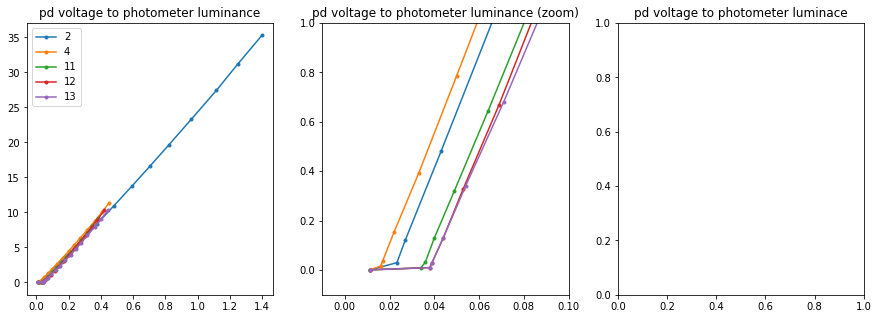

I chose 4 to represent the scans preceding 1/30/2021 (blanked)
 and 11 to represent the scans following 1/30/2021 (unblanked)


In [16]:
scan_dates = (experiment.Session & scan_keys)
scan_dates = scan_dates.proj('session_date').fetch(as_dict=True)

calib_rest = {'rig':'2P4'}
trial_dates = dj.U('trial').aggr(experiment.PhotodiodeCalibration & calib_rest,trial_date = 'MIN(ts)')

preceding_calib = []
for scan_date in scan_dates:
    date_diffs = trial_dates.proj(datediff = f'DATEDIFF("{scan_date["session_date"].isoformat()}",trial_date)')
    preceding_calib.append((date_diffs & 'datediff > 0').fetch('trial',order_by = 'datediff ASC',limit=1)[0])
    
print('for 9 included scans, the nearest preceding calibration curves (trial) are: ',
      sorted(list(set(preceding_calib))))

print('trial 2 is unblanked, but appears to have similar pd / luminance readings in relevant range')

print('trial 12 is a recently collected curve matching settings of trial 11')
print('trial 13 is a recently collected curve with updated settings (blanking on, matched luminance to 12)')

pd0 = 0.0113
lum0 = 0.001

fetch_str = ['trial','luminance','pd_voltage']
trials,lums,pds = (experiment.PhotodiodeCalibration & calib_rest &
                                         'trial in (2,4,11,12,13)').fetch(*fetch_str)
fig,(ax0,ax1,ax2) = plt.subplots(1,3,figsize=(15,5))
for trial in (2,4,11,12,13):
    trial_idx = trials==trial
    ax0.plot(np.concatenate(([pd0],pds[trial_idx])),
             np.concatenate(([lum0],lums[trial_idx])),'.-',label=str(trial))
    ax1.plot(np.concatenate(([pd0],pds[trial_idx])),
             np.concatenate(([lum0],lums[trial_idx])),'.-',label=str(trial))
    
ax1.set_xlim(-0.01,0.1)
ax1.set_ylim(-.1,1)
ax0.set_title('pd voltage to photometer luminance')
ax1.set_title('pd voltage to photometer luminance (zoom)')
ax2.set_title('pd voltage to photometer luminace')
_ = ax0.legend()
plt.show()
plt.close()

print('I chose 4 to represent the scans preceding 1/30/2021 (blanked)\n',
      'and 11 to represent the scans following 1/30/2021 (unblanked)')

In [11]:
coef = np.polyfit(pds[trials==4],lums[trials==4],1)

In [12]:
interp1d(np.concatenate(([pd0],pds[trials==4])),
         np.concatenate(([lum0],lums[trials==4])),
         kind='linear',fill_value='extrapolate')(0.02)

array(0.107)

In [9]:
np.concatenate(([pd0],pds[trials==4]))
np.concatenate(([lum0],lums[trials==4]))

array([1.000e-03, 1.600e-02, 3.800e-02, 1.530e-01, 3.910e-01, 7.860e-01,
       1.303e+00, 1.957e+00, 2.691e+00, 3.548e+00, 4.462e+00, 5.388e+00,
       6.344e+00, 7.519e+00, 8.847e+00, 9.995e+00, 1.133e+01])

In [12]:
poly1d_fn = np.poly1d(coef) 

In [22]:
interp1d(pds[trials==4],lums[trials==4],kind='linear',fill_value='extrapolate')(0.46)

array(11.63340909)

In [34]:
interp1d(pds[trials==11],lums[trials==11],kind='linear',fill_value='extrapolate')(0.02)

array(-0.152)

In [29]:
poly1d_fn(0.02)

-0.012429905790746987

In [4]:
blank_trials = stimulus.Trial & stimulus.Blank & (dj.U('animal_id','session') & scan_keys)
blank_count = dj.U('animal_id','session','scan_idx').aggr(blank_trials,n='count(trial_idx)')
mon_calib_candidates = (blank_count & 'n=52').proj()

calib_df = []
offset = 2000000

pixel_value = np.linspace(0, 255, 52)
pixel_value_for_fit = pixel_value.copy()
pixel_value_for_fit[0] = 1e-9

def func(x, a, b, m):
    return a + b * (x**m)



for key in tqdm(list(mon_calib_candidates)):
    session_date = (experiment.Session & key).fetch1('session_date')
    scan_path = (experiment.Scan & key).local_filenames_as_wildcard
    scan_dir = os.path.split(scan_path)[0]
    
    scan_file = (experiment.Scan & key).fetch1('filename')
    behavior_file = (experiment.Scan.BehaviorFile() & key).fetch1('filename')
    
    full_scan_file = os.path.join(scan_dir, f"{scan_file}_00001.tif")
    full_beh_file = os.path.join(scan_dir, behavior_file)
    
    scan_on = os.path.isfile(full_scan_file)
#     if os.path.isfile(full_beh_file):
    try:
        data = read_behavior_file(full_beh_file)
        
        if len(data["trialnum_ts"][1]) == 52:
            
            PD = data["syncPd"]

            ts = data["ts"]
            trial_starts = data["trialnum_ts"][1]

            # correct for counter that wraps at 2**32
            ts = ts + np.concatenate(([0],np.cumsum(np.diff(ts)<0))) * 2**32
            trial_starts = trial_starts + np.concatenate(([0],np.cumsum(np.diff(trial_starts)<0))) * 2**32

            # zero timestamps to first trial onset
            ts -= trial_starts[0]
            trial_starts -= trial_starts[0]

            # find median trial length
            med_trial_length = np.nanmedian(np.diff(trial_starts))

            # find calibration window
            #TODO sometimes no trials in window and not sure why (np.sum(window) == 0)
            calib_window = np.logical_and(ts>=trial_starts[0],ts<=trial_starts[-1]+med_trial_length)
            
            # max pd voltage
            max_voltage = np.nanmax(PD)
            
            pd_medians = np.array([np.nanmedian(PD[np.logical_and(ts>=s+offset,ts<=s+med_trial_length*0.95)]) 
                          for s in trial_starts])
            px2pd_params,_ = curve_fit(func,pixel_value_for_fit,pd_medians)
            
            calib_df.append({**key,'date':session_date,
                             'data':data,
                             'ts':ts,'PD':PD,'trial_starts':trial_starts,
                             'scan_on':scan_on, 
                             'med_trial_length':med_trial_length,
                             'calib_window':calib_window,
                             'max_volt':max_voltage,
                             'pd_medians':pd_medians,
                             'px2pd_params':px2pd_params})
            
            
            
            
            
    except OSError:
        print(f'skipping {"_".join([str(v) for v in key.values()])}, missing file')
        
calib_df = pd.DataFrame(calib_df)

100%|██████████| 22/22 [00:05<00:00,  4.19it/s]


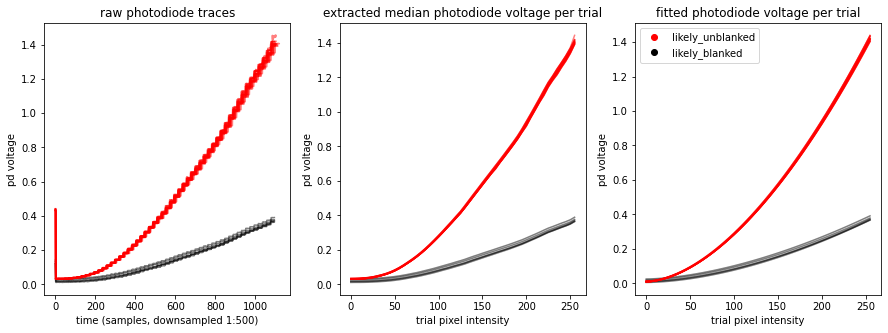

calibration scans collected in the early period were unblanked (no scanimage scan was simultaneously collected)

median min pd voltage (pixel 0):  0.0192
median max pd voltage (pixel 255):  0.3703
median gamma:  1.7093


,scan,pixel 0,pixel 255,gamma
0,26644_14_1,0.016589,0.370289,1.725896
1,26644_14_13,0.032711,0.389372,1.672785
2,26644_14_15,0.027117,0.376540,1.687410
3,26645_2_2,0.011653,0.365353,1.738267
4,26645_2_16,0.019221,0.364366,1.709339


In [5]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
likely_blanking = np.array([np.nanmax(PD)<0.5 for PD in calib_df['PD']])


PDs,windows = np.array(calib_df[likely_blanking][['PD','calib_window']]).T
for t,w in zip(PDs,windows):
    axes[0].plot(t[w][::500],'k',alpha=0.5)
    
PDs,windows = np.array(calib_df[~likely_blanking][['PD','calib_window']]).T
for t,w in zip(PDs,windows):
    axes[0].plot(t[w][::500],'r',alpha=0.5)
    
pd_medians = np.array(calib_df[likely_blanking]['pd_medians'])
for t in pd_medians:
    axes[1].plot(pixel_value_for_fit,t,'k',alpha=0.5)
    
pd_medians = np.array(calib_df[~likely_blanking]['pd_medians'])
for t in pd_medians:
    axes[1].plot(pixel_value_for_fit,t,'r',alpha=0.5)

    
px2pd_params = np.array(calib_df[likely_blanking]['px2pd_params'])
for p in px2pd_params:
    axes[2].plot(pixel_value_for_fit,func(pixel_value_for_fit,*p),'k',alpha=0.5)

px2pd_params = np.array(calib_df[~likely_blanking]['px2pd_params'])
for p in px2pd_params:
    axes[2].plot(pixel_value_for_fit,func(pixel_value_for_fit,*p),'r',alpha=0.5)


axes[0].set_title('raw photodiode traces')
axes[0].set_xlabel('time (samples, downsampled 1:500)')
axes[0].set_ylabel('pd voltage')
axes[1].set_title('extracted median photodiode voltage per trial')
axes[1].set_xlabel('trial pixel intensity')
axes[1].set_ylabel('pd voltage')
axes[2].set_title('fitted photodiode voltage per trial')
axes[2].set_xlabel('trial pixel intensity')
axes[2].set_ylabel('pd voltage')

legend_dict = {'likely_unblanked': 'r', 
               'likely_blanked' : 'k'}

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in legend_dict.values()]
_ = plt.legend(markers, legend_dict.keys(), numpoints=1)

plt.show()
plt.close()

print('calibration scans collected in the early period were',
       'unblanked (no scanimage scan was simultaneously collected)\n')

blanked_df = []
ext_strs = ['animal_id','session','scan_idx','px2pd_params','pd_medians']
for animal_id,session,scan,px2pd_params,pd_medians in np.array(calib_df[likely_blanking][[*ext_strs]]):
    scan_str = '_'.join([str(s) for s in [animal_id,session,scan]])
    blanked_df.append({'scan':scan_str,
                       'pixel 0':pd_medians[0],
                       'pixel 255':pd_medians[-1],
                       'gamma':px2pd_params[-1]})
blanked_df = pd.DataFrame(blanked_df)
med_min_pd = np.nanmedian(blanked_df['pixel 0'])
med_max_pd = np.nanmedian(blanked_df['pixel 255'])
med_gamma = np.nanmedian(blanked_df['gamma'])
print('median min pd voltage (pixel 0): ', np.round(med_min_pd,4))
print('median max pd voltage (pixel 255): ', np.round(med_max_pd,4))
print('median gamma: ', np.round(med_gamma,4))

display(blanked_df)



Interpolating the photodiode values from the calibration scans appears to be unhelpful, since majority are unblanked (before 1/30), and remainder after 1/30 only apply to two scans which were collected under differet imaging conditions.  

Interpolating monitor calibration pd values after 1/30 for curves before 1/30 is likely to be inaccurate, as different power settings (before blanking) appear to have an baseline offset effect.  

Additionally, interpolating the pd values from the calibration scans after 1/30 appear to fall outside the range of the pd->photometer calibration scans, likely due to a warmup effect resulting in higher monitor luminance (both on photometer and pd metrics) that is absent in monitor calibration scans collected per session early in the day. 


In [7]:
blanked_pd2lum = interp1d(pds[trials==4],lums[trials==4],kind='linear',fill_value='extrapolate')
unblanked_pd2lum = interp1d(pds[trials==11],lums[trials==11],kind='linear',fill_value='extrapolate')

print(blanked_pd2lum((med_min_pd,med_max_pd)))
print(unblanked_pd2lum((med_min_pd,med_max_pd)))

[0.08908079 8.9950796 ]
[-0.1609596   8.78294911]


In [12]:
print(blanked_pd2lum((0.46)))
print(unblanked_pd2lum((0.46)))

11.633409090909092
11.556314285714281


Thus, the most accurate representation of the monitor performance during a scan is likely to come from the higher values recorded during a pd-> photometer calibration, and not from a pixel->pd monitor calibration scan per session.  Thus, the min / max luminance values will come from the pd->photometer curve, which was also collected per pixel value.  

In [8]:
print('trial 4 luminance range (0-255): ', np.round(np.min(lums[trials==4]),4),'-',np.round(np.max(lums[trials==4]),4))
print('trial 11 luminance range (0-255): ', np.round(np.min(lums[trials==11]),4),'-',np.round(np.max(lums[trials==11]),4))
print('trial 12 luminance range (0-255): ', np.round(np.min(lums[trials==12]),4),'-',np.round(np.max(lums[trials==12]),4))
print('trial 13 luminance range (0-255): ', np.round(np.min(lums[trials==13]),4),'-',np.round(np.max(lums[trials==13]),4))

trial 4 range (0-255):  0.016 - 11.33
trial 11 range (0-255):  0.009 - 9.145
trial 12 range (0-255):  0.01 - 10.31
trial 13 range (0-255):  0.01 - 10.32


In [11]:
print('trial 4 photodiode range (0-255): ', np.round(np.min(pds[trials==4]),4),'-',np.round(np.max(pds[trials==4]),4))
print('trial 11 photodiode range (0-255): ', np.round(np.min(pds[trials==11]),4),'-',np.round(np.max(pds[trials==11]),4))
print('trial 12 photodiode range (0-255): ', np.round(np.min(pds[trials==12]),4),'-',np.round(np.max(pds[trials==12]),4))
print('trial 13 photodiode range (0-255): ', np.round(np.min(pds[trials==13]),4),'-',np.round(np.max(pds[trials==13]),4))

trial 4 photodiode range (0-255):  0.016 - 0.45
trial 11 photodiode range (0-255):  0.034 - 0.382
trial 12 photodiode range (0-255):  0.038 - 0.421
trial 13 photodiode range (0-255):  0.038 - 0.444


From the monitor calibration scan per session, we can estimate the gamma curve.  Notably, the function used doesn't actually seem to fit the curve very well, especially at low values.  It does allow us to estimate the gamma value from the curve at ~1.709 (see median gamma above)

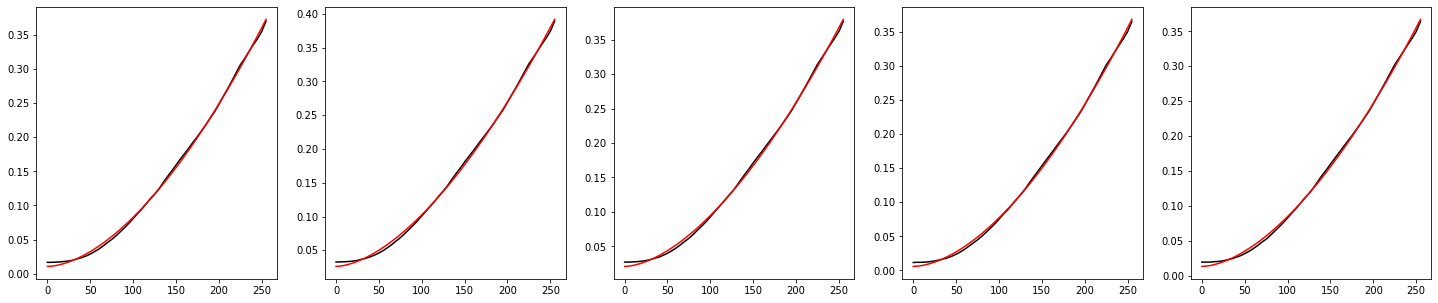

In [10]:
fig,axes = plt.subplots(1,5,figsize=(25,5))
for ax,pd_median,px2pd_params in zip(axes,*np.array(calib_df[likely_blanking][['pd_medians','px2pd_params']]).T):
    ax.plot(pixel_value_for_fit,pd_median,'k')
    ax.plot(pixel_value_for_fit,func(pixel_value_for_fit,*px2pd_params),'r')